# Initialisation

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex
#plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
# plt.rcParams.update({
#     "text.usetex": True,
#     #"font.family": "Times New Roman",
#     "font.family": "Libertine",
#     "font.size": 12
# })

plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu

from os.path import expanduser
base = expanduser("~")
from IPython.display import display, Math, Latex

################################
## Auteur : Christoophe Ancey ##
## Date : octobre 2024        ##
################################

#-------------------------------------------
# Fonctions 
#-------------------------------------------
def trouver_période_continue(liste):
    """ 
    fournit l'ensemble des sous-listes telles que chacun des éléments est séparé de l'élément par 1.
    Cette fonction permet de déterminer dans la série d'années avec des cumuls non nuls les séries continues
    d'années.
    """
    res, last = [[]], None
    for x in liste:
        if last is None or abs(last - x) ==1:
            res[-1].append(x)
        else:
            res.append([x])
        last = x
    return res

def Tracer_maxi(maxi,ax):
      na = len(maxi)
      maxi.sort()
      période = [(na+0.28)/(na-i-1+0.56) for i in range(na)]
      ax.scatter(période,maxi,  marker = "o",edgecolors='white', s=45, color='deepskyblue', alpha = 1)

def Trouver_maxi_annuels(série):
      maxi_valeur =  série.groupby(by=[série.index.year]).max().values
      maxi_date   =  série.groupby(by=[série.index.year]).max().index
      bloc_date   = []
      bloc_maxi   = []
      for i in range(len(maxi_date)): 
            selection =  série[(série==maxi_valeur[i]) & (série.index.year==maxi_date[i])] 
            date_occurrence = selection.index[0]
            valeur = selection.iloc[0]
            bloc_date.append(date_occurrence)
            bloc_maxi.append(valeur)
      série_max = pd.Series(bloc_maxi,index = bloc_date)
      return série_max, bloc_maxi   

def convertir_date(date,format='complet'):
    if format == 'simple':
        return datetime.datetime.strptime(date.to_string(index = False)  ,"%Y-%m-%d").strftime("%d/%m/%Y")
    else:
        return date.iloc[0].strftime('%Y-%m-%d')

# Lecture des données

In [3]:
# adresse du fichier
# à changer selon besoin
# 'base' est l'adresse de mon espace personnel
répertoire_travail = base + "/rhône/"
os.chdir(répertoire_travail)
débit      = pd.read_csv(répertoire_travail+'rhone.csv', sep=";",skiprows=8,encoding = "ISO-8859-1")


In [4]:
débit

,Stationsname,Stationsnummer,Parameter,Zeitreihe,Parametereinheit,Gewässer,Zeitstempel,Zeitpunkt_des_Auftretens,Wert,Freigabestatus
0,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,01.01.1905 00:00,NaN,40.000,"Freigegeben, validierte Daten"
1,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,02.01.1905 00:00,NaN,31.000,"Freigegeben, validierte Daten"
2,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,03.01.1905 00:00,NaN,34.000,"Freigegeben, validierte Daten"
3,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,04.01.1905 00:00,NaN,71.300,"Freigegeben, validierte Daten"
4,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,05.01.1905 00:00,NaN,87.600,"Freigegeben, validierte Daten"
...,...,...,...,...,...,...,...,...,...,...
43740,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,03.10.2024 00:00,NaN,234.444,"Nicht freigegeben, Rohdaten"
43741,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,04.10.2024 00:00,NaN,221.665,"Nicht freigegeben, Rohdaten"
43742,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,05.10.2024 00:00,NaN,193.267,"Nicht freigegeben, Rohdaten"
43743,Porte du Scex,2009,Abfluss,Tagesmittel,m3/s,Rhône,06.10.2024 00:00,NaN,149.649,"Nicht freigegeben, Rohdaten"


In [5]:
format_date_fichier = 'simple'
débit.Zeitstempel= débit.Zeitstempel .apply(lambda x: pd.to_datetime(x[0:10],format='%d.%m.%Y' ))
série_débit = pd.Series(np.array(débit['Wert']),index=np.array(débit['Zeitstempel'])).squeeze()
série_débit

1905-01-01     40.000
1905-01-02     31.000
1905-01-03     34.000
1905-01-04     71.300
1905-01-05     87.600
               ...   
2024-10-03    234.444
2024-10-04    221.665
2024-10-05    193.267
2024-10-06    149.649
2024-10-07    169.968
Length: 43745, dtype: float64

# Chronique des débits

Le maximum a été atteint le 2000-10-15 avec un cumul journalier de 1047.4 m3/s.


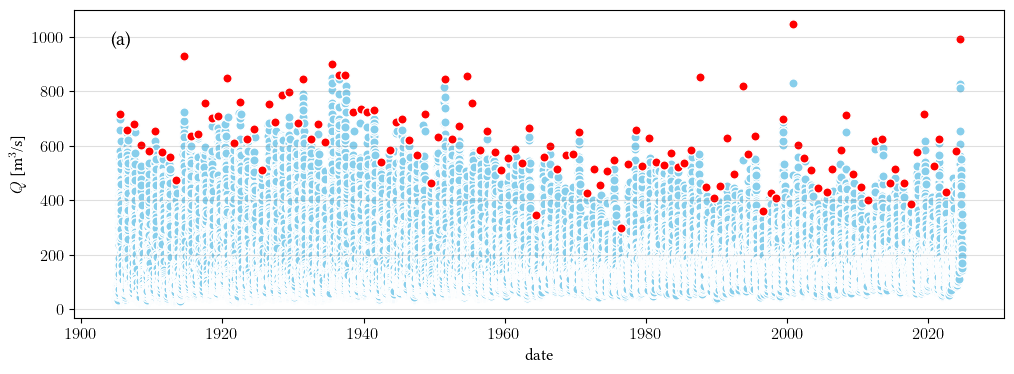

In [6]:
maxi_annuels_1j, maxi_annuels_val = Trouver_maxi_annuels(série_débit)

# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_débit.index, série_débit ,  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'$Q$ [m$^3$/s] ')
ax.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)
ax.scatter( maxi_annuels_1j.index,maxi_annuels_1j ,  marker = "o",edgecolors='white', s=45, color='red', alpha = 1)

date_max = débit[débit['Wert']==np.nanmax(débit['Wert'])]['Zeitstempel']
date_max = convertir_date(date_max)
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} m3/s.".format(np.nanmax(débit['Wert']))   )
ax.text(0.05, 0.9,  '(a)',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,fontsize=14)
fig.savefig("chronique-rhone.png",dpi=300, bbox_inches='tight')


# Calage d'une loi de valeurs extrêmes

On commence par caler une loi de valeurs extrêmes (soit Gumbel, soit Weibull/Fréchet) à l'aide de la méthode du maximum de vraisemblance.

In [10]:
# Calage par la méthode du maximum de vraisemblance
calage_gumbel = gumbel_r.fit(maxi_annuels_val)
calage_gev    = genextreme.fit(maxi_annuels_val)

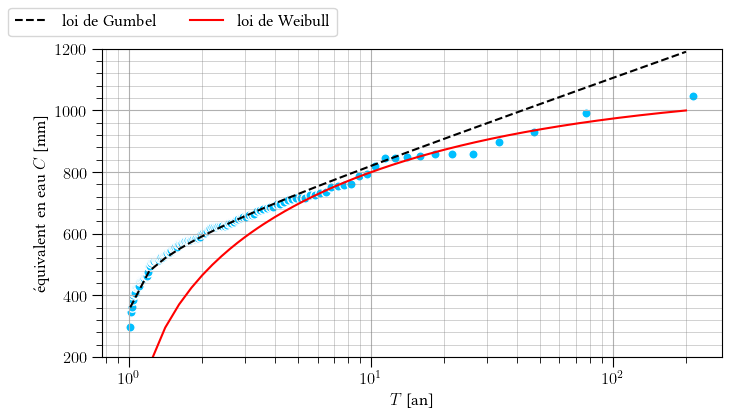

In [11]:
# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
(mu_g, sigma_g) = calage_gumbel

# Tracé

if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'
période = np.linspace(1.01,200,1000)
quantile_gev  = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"équivalent en eau $C$ [mm]")
axes.set_ylim( [200,1200])
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )

axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.plot(période,quantile_gev(période),'-',color='red' , label = "loi de "+nom_loi)

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=2)

# Loi de mélange

On va caler une loi de mélange combinant deux lois de Gumbel. Voir § 4.6.2 de mon cours. Pour obtenir une première estimation on divise l'échantillon en deux groupes 'ordinaires' et 'rares' avec un seuil arbitrairement fixé à 600 m$^3$/s.

In [12]:
seuil = 600
maxi_annuels_val = np.array(maxi_annuels_val)
ordinaires = maxi_annuels_val[maxi_annuels_val<seuil]
rares = maxi_annuels_val[maxi_annuels_val>=seuil]
calage_gumbel_ordinaire = gumbel_r.fit(ordinaires)
calage_gumbel_rare = gumbel_r.fit(rares)
p = len(ordinaires)/len(maxi_annuels_val)
 

In [166]:
from scipy.optimize import fsolve
import scipy.optimize as optimize
import scipy.special as sc

def LVE_cdf(x,m,a,xi):
    if xi != 0:
        if x > m-a/xi:
            cdf = np.exp(- (1+xi (x-m)/a) **(-1/xi))
        else:
            cdf = 0
    else:
        cdf = np.exp(-np.exp(-(x-m)/a))
    return cdf

def LVE_pdf(x,m,a,xi):
    if xi > 0:
        if x > m-a/xi:
            pdf = (np.exp(((-(1+(((x-m)*xi)/a))**(-1/xi)))))*((1.+(((x-m)*xi)/a))**(-1-1/xi))/a
        else:
            pdf = 0
    elif xi<0:
        if x < m-a/xi:
            pdf = (np.exp(((-(1+(((x-m)*xi)/a))**(-1/xi)))))*((1.+(((x-m)*xi)/a))**(-1-1/xi))/a
        else:
            pdf = 0
    else:
        pdf = (np.exp((((m-x)/a)-(np.exp(((m-x)/a))))))/a
    return pdf

def mélange_pdf(x,p,m1,a1,xi1,m2,a2,xi2):
    return p*LVE_pdf(x,m1,a1,xi1)+(1-p)*LVE_pdf(x,m2,a2,xi2)

def mélange_cdf(x,p,m1,a1,xi1,m2,a2,xi2):
    return p*LVE_cdf(x,m1,a1,xi1)+(1-p)*LVE_cdf(x,m2,a2,xi2)

def flatten(data):
    if isinstance(data, tuple):
        if len(data) == 0:
            return ()
        else:
            return flatten(data[0]) + flatten(data[1:])
    else:
        return (data,)
    
def mélange_quantile(T,p,m1,a1,xi1,m2,a2,xi2,x0):
    sol = fsolve(lambda x: mélange_cdf(x,p,m1,a1,xi1,m2,a2,xi2)-(1-1/T), x0)
    return sol[0]

def logpdf(x,m,s):
    return np.log(LVE_pdf(x,m,s,0))

def fncQ_1(params):
    (m,s) = params
    somme = np.array([-logpdf(maxi_annuels_val[i],m,s)*w1[i] for i in range(n)]).sum()
    return somme

def fncQ_2(params):
    (m,s) = params
    somme = np.array([-logpdf(maxi_annuels_val[i],m,s)*w2[i] for i in range(n)]).sum()
    return somme

def log_vraisemblance(params):
    prob = np.array([np.log(mélange_pdf(maxi_annuels_val[i],*params)) for i in range(n)])
    return prob.sum()

def pearson(x,m,alpha,lam):
    if alpha*(x-m)>0:
        output = abs(alpha)/sc.gamma(lam)*np.exp(-alpha*(x-m))*(alpha*(x-m))**(lam-1)
    else:
        output = 0
    return output

def log_pearson(x,m,alpha,lam):
    # Cette fonction pose des problèmes car il y a des nombres potentiellement grands
    output1 = m*alpha +(-1-alpha)*np.log(x)+np.log(abs(alpha))
    output2 = np.log(alpha*(np.log(x)-m))*(lam-1)-np.log(sc.gamma(lam))
    return np.exp(output1+output2)

def log_pearson_cdf(x,m,alpha,lam):
    output =  sc.gammaincc(lam,-alpha* (m-np.log(x)))/sc.gamma(lam)*sc.gamma(lam)
    return output

def log_pearson_quantile(T,m,alpha,lam,x0):
    sol = fsolve(lambda x: log_pearson_cdf(x,m,alpha,lam)-(1-1/T), x0)
    return sol[0]
         

In [113]:

liste_log_vraisemblance = []
liste_solution = []
(mu1,si1,xi1)=flatten((calage_gumbel_ordinaire,0))
(mu2,si2,xi2)=flatten((calage_gumbel_rare,0))

n = len(maxi_annuels_val)
for k in range(50):

    paramètres = flatten((p,(mu1,si1,xi1),(mu2,si2,xi2)))
    w1 = [ LVE_pdf(maxi_annuels_val[i],mu1,si1,xi1)/mélange_pdf(maxi_annuels_val[i],*paramètres)*p for i in range(n)]
    w2 = [ LVE_pdf(maxi_annuels_val[i],mu2,si2,xi2)/mélange_pdf(maxi_annuels_val[i],*paramètres)*(1-p) for i in range(n)]
    p  = np.mean(w1)
    sol1 = optimize.minimize(fncQ_1,[mu1,si1])
    [mu1,si1]=sol1.x
    sol2 = optimize.minimize(fncQ_2,[mu2,si2])
    [mu2,si2]=sol2.x
    ell = log_vraisemblance((p,mu1,si1,0,mu2,si2,0))
    liste_log_vraisemblance.append(ell)
    liste_solution.append([ p,mu1,si1,0, mu2,si2,0])

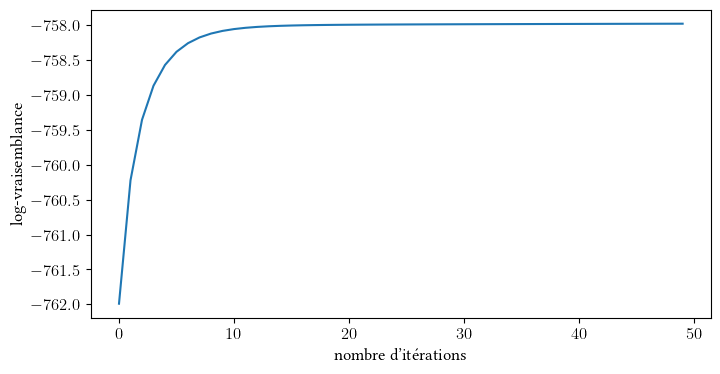

In [114]:
# convergence de la log-vraisemblance
fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"nombre d'itérations")
axes.set_ylabel(r"log-vraisemblance")
axes.plot(liste_log_vraisemblance)

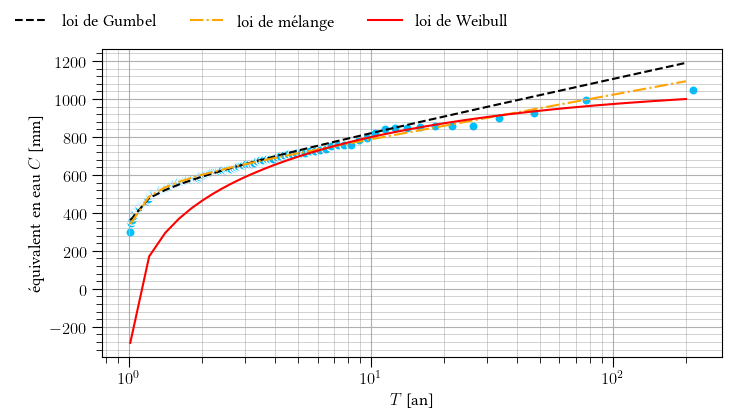

In [115]:
# loi LVE
(xi, mu, sigma) = calage_gev
xi = -xi # Attention dans scipy, xi n'a pas le même signe que dans le cours !
# loi de Gumbel
(mu_g, sigma_g) = calage_gumbel
# loi de mélange
solution_mélange = liste_solution[-1]
guess_quantile = np.mean(maxi_annuels_val) # nécessaire pour avoir un point de départ dans la recherche des quantiles dans la fonction mélange_quantile
# nom de la loi LVE
if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'

#liste des périodes retour
période = np.linspace(1.01,200,1000)
# quantiles en fct de T
quantile_gev    = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

# figure
fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"équivalent en eau $C$ [mm]")
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )

quantiles_mélange = [mélange_quantile(T, *solution_mélange,guess_quantile) for T in période]
axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.semilogx(période,quantiles_mélange,'-.',color='orange' , label = "loi de mélange")
axes.semilogx(période,quantile_gev(période),'-',color='red' , label = "loi de "+nom_loi)

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=3,frameon=False)
fig.savefig('mixture.png',dpi=300,bbox_inches='tight')

In [165]:
# examen et comparaison des trois lois
l_g   = np.array([np.log(LVE_pdf(maxi_annuels_val[i],mu_g, sigma_g,0)) for i in range(n)]).sum()
l_lve = np.array([np.log(LVE_pdf(maxi_annuels_val[i],mu, sigma,xi)) for i in range(n)]).sum()
l_mel = liste_log_vraisemblance[-1]

tableau_résultat=[
    ['','Gumbel','LVE','mélange'],
    ['k','2','3','5'],
    [r'$\ell$',l_g,l_lve,l_mel],
    ['AIC',2*2-2*l_g,2*3-2*l_lve,2*5-2*l_mel]
]
print(tabulate(tableau_résultat))

------  ------------------  ------------------  ------------------
        Gumbel              LVE                 mélange
k       2                   3                   5
$\ell$  -760.5677839931318  -815.7537535391768  -757.9760047771531
AIC     1525.1355679862636  1637.5075070783537  1525.9520095543062
------  ------------------  ------------------  ------------------


# Loi de log-Pearson III

In [72]:
from scipy.stats import skew
from statistics import variance
from scipy.stats import pearson3

## Calage d'après la notation du cours

In [167]:
# comme scipy n'a pas la loi de log-Pearson III, on utilise la loi de Pearson III sur le logarithme de l'échantillon
log_sample = np.log(maxi_annuels_val)
γ = skew(log_sample)
var = variance(log_sample)
λ = (2/γ)**2
α = np.sqrt(λ/var) # Attention le signe peut être négatif !
m = np.mean(log_sample)-λ/α
# calage par la méthode des moments
print(f"m = {m:.2f}, α = {α:.2f} ou α = {-α:.2f} et λ = {λ:.2f}")


m = 3.97, α = 47.38 ou α = -47.38 et λ = 114.88



Il existe une correspondance entre la formulation utilisée dans scipy [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearson3.html](Scipy) :
$$
f(x,\kappa) = \frac{|\beta|}{\Gamma(\alpha)}( \beta(x-\zeta))^{\alpha-1}\exp(-\beta(x-\zeta))
$$
avec :
* $\beta=2/\kappa$
* $\alpha=4/\kappa^2$
* $\zeta=-\beta$

et la formulation utilisée dans le cours (voir annexe A.2.10). La forme canonique utilisée par Scipy ne fait intervenir que le coefficient d'asymétrie $\kappa$ (skewness), dont dépend les trois autres paramètres $\alpha$, $\beta$ et $\zeta$. Scipy précise que la loi classique à trois paramètres est recouvrée en posant le changement de variable
$$
y = \frac{x-loc}{scale}.
$$
La loi de probabilité est alors :
$$
g(y)=\frac{1}{scale}f(y).
$$
Dans le cours on avait posé :
$$
f(x) = \frac{|\alpha|}{\Gamma(\lambda)}\exp^{-\alpha(x-m)}(\alpha(x-m))^{\lambda-1}\text{ pour }x>m
$$
La comparaison des deux formes nous donne donc la correspondance :
$$
\begin{aligned}
\kappa &= \frac{2}{\sqrt{\lambda }}\\
 scale &= \frac{\sqrt{\lambda}}{\alpha}\\
 loc   &= m+\frac{\lambda}{\alpha}\\
\end{aligned}
$$
ou inversement
$$
\begin{aligned}
\lambda &= \frac{4}{\kappa^2}\\
 \alpha &= \frac{2}{scale\,\kappa}\\
 m   &= loc-\frac{2}{\kappa }scale\\
\end{aligned}
$$

## Calage à partir de python par la méthode du maximum de vraisemblance

In [168]:
# calage des paramètres dans scipy (par la méthode du maximum de vraisemblance)
skewness, loc, scale = pearson3.fit(log_sample)
print(f"κ = {skewness:.2f}, loc = {loc:.2f} et scale = {scale:.2f}")

κ = -0.17, loc = 6.39 et scale = 0.23


In [171]:
# valeurs des paramètres λ, α et m par la méthode du maximum de vraisemblance
λ_mv = 4/skewness**2
α_mv = 2/scale/skewness
m_mv = loc-2/skewness*scale
print(f"* Méthode du maximum de vraisemblance : m = {m_mv:.2f}, α = {α_mv:.2f} et λ = {λ_mv:.2f}")

print(f"* Méthode des moments                 : m = {m:.2f}, α = {α:.2f} ou α = {-α:.2f} et λ = {λ:.2f}")

* Méthode du maximum de vraisemblance : m = 9.04, α = -52.24 et λ = 138.42
* Méthode des moments                 : m = 3.97, α = 47.38 ou α = -47.38 et λ = 114.88


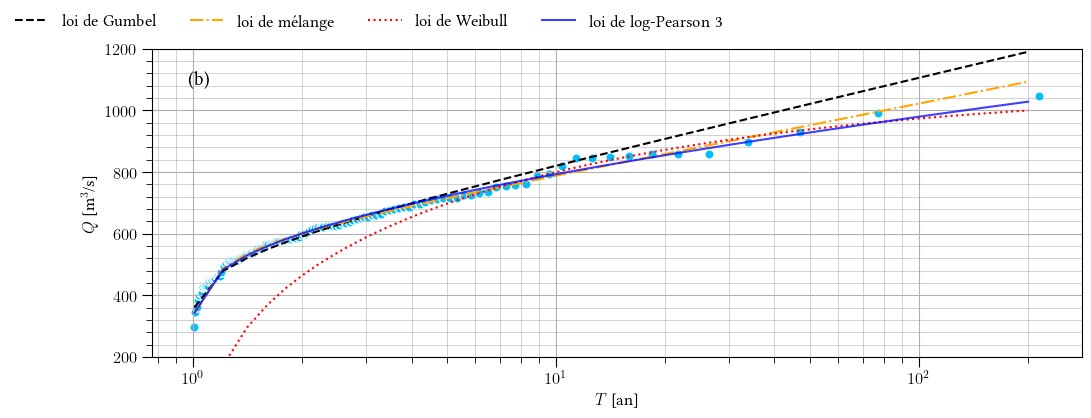

In [177]:
# loi LVE
(xi, mu, sigma) = calage_gev
xi = -xi
# loi de Gumbel
(mu_g, sigma_g) = calage_gumbel
# loi de mélange
solution_mélange = liste_solution[-1]
guess_quantile = np.mean(maxi_annuels_val)
if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'
période = np.linspace(1.01,200,1000)

# quantiles LVE
quantile_gev    = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

# figure
fig, axes = plt.subplots(figsize=(12,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"  $Q$ [m$^3$/s]")
axes.set_ylim( [200,1200])
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )

axes.text(0.05, 0.9,  '(b)',
        horizontalalignment='center',
        verticalalignment='center',
        transform = axes.transAxes,fontsize=14)

quantiles_pearson = [np.exp(pearson3.ppf(1-1/T,skew=skewness,loc=loc,scale=scale)) for T in période]
quantiles_mélange = [mélange_quantile(T, *solution_mélange,guess_quantile) for T in période]
axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.semilogx(période,quantiles_mélange,'-.',color='orange' , label = "loi de mélange")
axes.semilogx(période,quantile_gev(période),linestyle='dotted',color='red' , label = "loi de "+nom_loi)
axes.semilogx(période,quantiles_pearson,'-',color='blue' , alpha=0.75, label = 'loi de log-Pearson 3')

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=4,frameon=False)


fig.savefig('pearson.png',dpi=300,bbox_inches='tight')

# Calage de la log-vraisemblance par la méthode des moments : méthode de Bobée (1975)

In [173]:
# On calcule les moments non centrés
M_1 = np.array([v for v in maxi_annuels_val]).sum()/n
M_2 = np.array([v**2 for v in maxi_annuels_val]).sum()/n
M_3 = np.array([v**3 for v in maxi_annuels_val]).sum()/n

In [174]:
# On en déduit les valeurs des paramètres
# Voir Bobée, B., The log Pearson type 3 distribution and its application in hydrology, Water Resources Research, 11 (5), 681-689, 1975.
# ou annexes du cours
B   = (np.log(M_3)-3*np.log(M_1))/(np.log(M_2)-2*np.log(M_1))
fnc = lambda a: np.log((1-1/a)**3/(1-3/a))-B*np.log((1-1/a)**2/(1-2/a))
alpha_lp  = fsolve(fnc,-50)[0]
lambda_lp = (np.log(M_2)-2*np.log(M_1))/np.log(((1-1/alpha_lp)**2/(1-2/alpha_lp)))
m_lp      = np.log(M_1)+lambda_lp*np.log(1-1/alpha_lp) 
print(f"* Méthode des moments                 : m = {m_lp:.2f}, α = {alpha_lp:.2f} et λ = {lambda_lp:.2f}")

* Méthode des moments                 : m = 9.32, α = -58.01 et λ = 170.16


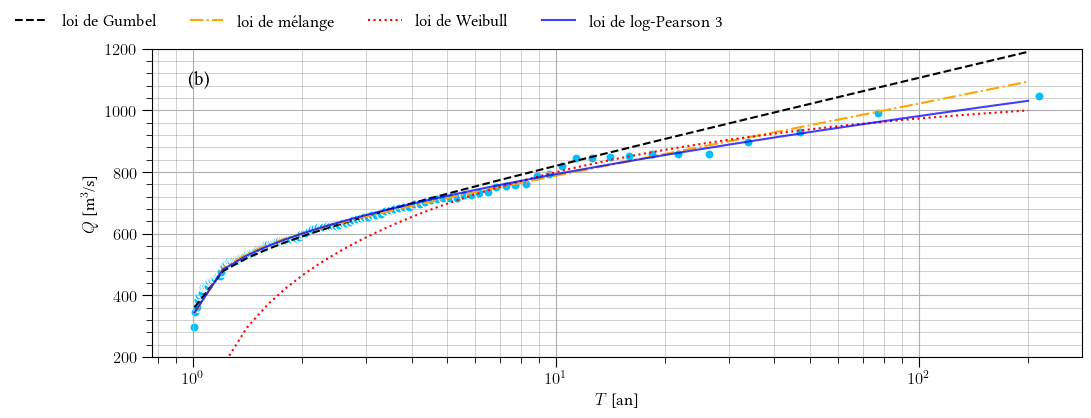

In [175]:
# loi LVE
(xi, mu, sigma) = calage_gev
xi = -xi
# loi de Gumbel
(mu_g, sigma_g) = calage_gumbel
# loi de mélange
solution_mélange = liste_solution[-1]
guess_quantile = np.mean(maxi_annuels_val)
if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'
période = np.linspace(1.01,200,1000)

# quantiles LVE
quantile_gev    = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

# figure
fig, axes = plt.subplots(figsize=(12,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"  $Q$ [m$^3$/s]")
axes.set_ylim( [200,1200])
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )

axes.text(0.05, 0.9,  '(b)',
        horizontalalignment='center',
        verticalalignment='center',
        transform = axes.transAxes,fontsize=14)


quantiles_pearson = [log_pearson_quantile(T,m_lp,alpha_lp,lambda_lp,np.mean(maxi_annuels_val)) for T in période]
quantiles_mélange = [mélange_quantile(T, *solution_mélange,guess_quantile) for T in période]
axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.semilogx(période,quantiles_mélange,'-.',color='orange' , label = "loi de mélange")
axes.semilogx(période,quantile_gev(période),linestyle='dotted',color='red' , label = "loi de "+nom_loi)
axes.semilogx(période,quantiles_pearson,'-',color='blue' , alpha=0.75, label = 'loi de log-Pearson 3')

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=4,frameon=False)


fig.savefig('pearson.png',dpi=300,bbox_inches='tight')

## Comparaison des méthodes

In [176]:
l_pearson = np.array([np.log(log_pearson(maxi_annuels_val[i],m_lp,alpha_lp,lambda_lp))    for i in range(n)]).sum()
tableau_résultat=[
    ['','Gumbel','LVE','mélange','log-Pearson 3'],
    ['k','2','3','5','3'],
    [r'$\ell$',l_g,l_lve,l_mel,l_pearson],
    ['AIC',2*2-2*l_g,2*3-2*l_lve,2*5-2*l_mel,2*3-l_pearson*2]
]
print(tabulate(tableau_résultat))

------  ------------------  ------------------  ------------------  ------------------
        Gumbel              LVE                 mélange             log-Pearson 3
k       2                   3                   5                   3
$\ell$  -760.5677839931318  -815.7537535391768  -757.9760047771531  -758.0967322132726
AIC     1525.1355679862636  1637.5075070783537  1525.9520095543062  1522.1934644265452
------  ------------------  ------------------  ------------------  ------------------
